In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [3]:
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import numpy as np

In [4]:
train_datagen=ImageDataGenerator(rescale=1./255,horizontal_flip=True,
                                 rotation_range=.2,shear_range=.2,zoom_range=.2)
test_datagen=ImageDataGenerator(rescale=1./255)

In [5]:
training_set=train_datagen.flow_from_directory("/content/drive/MyDrive/Cotton_Dataset/train",target_size=(224,224),
                                               batch_size=20,class_mode="categorical",shuffle=True)
test_set=test_datagen.flow_from_directory("/content/drive/MyDrive/Cotton_Dataset/test",target_size=(224,224),
                                               batch_size=20,class_mode="categorical",shuffle=True)

Found 1951 images belonging to 4 classes.
Found 18 images belonging to 4 classes.


In [6]:
folder= glob("/content/drive/MyDrive/Cotton_Dataset/train/*")
print ("The classes are ")
folder

The classes are 


['/content/drive/MyDrive/Cotton_Dataset/train/fresh cotton leaf',
 '/content/drive/MyDrive/Cotton_Dataset/train/fresh cotton plant',
 '/content/drive/MyDrive/Cotton_Dataset/train/diseased cotton leaf',
 '/content/drive/MyDrive/Cotton_Dataset/train/diseased cotton plant']

In [20]:
def build_model(hp):
  cnn_model=keras.Sequential([
                              keras.layers.Conv2D(filters=hp.Int("Conv_1_filter", min_value=32, max_value=128,step=16),activation="relu",
                                                  kernel_size=hp.Choice("Conv_1_filter_size",values=[3,5]),input_shape=[224,224,3]),
                              keras.layers.Conv2D(filters=hp.Int("Conv_2_filter", min_value=64, max_value=128,step=16),activation="relu",
                                                  kernel_size=hp.Choice("Conv_2_filter_size",values=[3,5])),
                              keras.layers.Conv2D(filters=hp.Int("Conv_3_filter", min_value=64, max_value=128,step=16),activation="relu",
                                                  kernel_size=hp.Choice("Conv_3_filter_size",values=[3,5])),
                              keras.layers.MaxPool2D(pool_size=hp.Choice("Maxpool_1",values=[2,3,5])),
                              keras.layers.Conv2D(filters=hp.Int("Conv_4_filter", min_value=64, max_value=128,step=16),activation="relu",
                                                  kernel_size=hp.Choice("Conv_4_filter_size",values=[3,5])),
                              keras.layers.Conv2D(filters=hp.Int("Conv_5_filter", min_value=64, max_value=128,step=16),activation="relu",
                                                  kernel_size=hp.Choice("Conv_5_filter_size",values=[3,5])),
                              keras.layers.MaxPool2D(pool_size=hp.Choice("Maxpool_2",values=[2,3,5])),
                              keras.layers.Conv2D(filters=hp.Int("Conv_6_filter", min_value=32, max_value=128,step=16),activation="relu",
                                                  kernel_size=hp.Choice("Conv_6_filter_size",values=[3,5])),
                              keras.layers.Conv2D(filters=hp.Int("Conv_7_filter", min_value=32, max_value=128,step=16),activation="relu",
                                                  kernel_size=hp.Choice("Conv_7_filter_size",values=[3,5])),
                              keras.layers.Flatten(),
                              keras.layers.Dense(units=hp.Int("Dense_1_neurons", min_value=4, max_value=10,step=1),activation="relu"),
                              keras.layers.Dense(units=len(folder),activation="softmax")

  ])
  cnn_model.compile(optimizer=keras.optimizers.Adam(hp.Choice("Learning_rate", values=[.01,.001,.0001])),
                    loss="categorical_crossentropy",metrics=["accuracy"])
  return cnn_model


In [14]:
pip install keras-tuner

In [15]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [21]:
tuner_search=RandomSearch(build_model,objective="accuracy",max_trials=4,
                          directory="output",project_name="Cotton_decease_detection")

In [22]:
tuner_search.search(training_set,epochs=5)

Trial 4 Complete [00h 03m 11s]
accuracy: 0.4177345037460327

Best accuracy So Far: 0.531522274017334
Total elapsed time: 00h 12m 53s
INFO:tensorflow:Oracle triggered exit


In [23]:
r=tuner_search.get_best_models(num_models=1)[0]

In [24]:
CNN_model=r.fit_generator(training_set,epochs=50,initial_epoch=5,
                          validation_data=test_set,steps_per_epoch=len(training_set),validation_steps=len(test_set))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 6/50
98/98 [==============================] - 46s 464ms/step - loss: 1.0499 - accuracy: 0.5501 - val_loss: 0.9807 - val_accuracy: 0.5000
Epoch 7/50
98/98 [==============================] - 42s 424ms/step - loss: 1.0473 - accuracy: 0.5547 - val_loss: 1.0048 - val_accuracy: 0.5556
Epoch 8/50
98/98 [==============================] - 42s 427ms/step - loss: 1.0178 - accuracy: 0.5685 - val_loss: 1.2134 - val_accuracy: 0.5000
Epoch 9/50
98/98 [==============================] - 42s 433ms/step - loss: 0.9912 - accuracy: 0.5582 - val_loss: 0.9921 - val_accuracy: 0.5556
Epoch 10/50
98/98 [==============================] - 42s 426ms/step - loss: 1.0044 - accuracy: 0.5730 - val_loss: 1.0154 - val_accuracy: 0.4444
Epoch 11/50
98/98 [==============================] - 42s 431ms/step - loss: 0.9675 - accuracy: 0.5921 - val_loss: 1.2067 - val_accuracy: 0.4444
Epoch 12/50
98/98 [==============================] - 42s 428ms/step - loss: 0.9677 - accuracy: 0.5816 - val_loss: 1.3303 - val_accuracy: 0.5

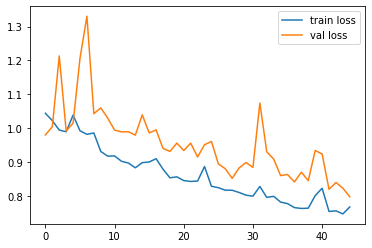

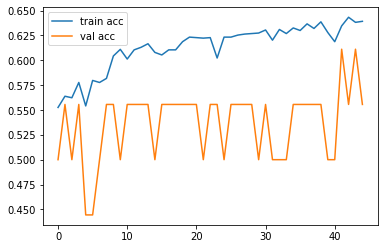

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

# plot the loss
plt.plot(CNN_model.history['loss'], label='train loss')
plt.plot(CNN_model.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(CNN_model.history['accuracy'], label='train acc')
plt.plot(CNN_model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [28]:
r.save("model_cnn_cotton.h5")

In [29]:
from tensorflow.keras.models import load_model
model_cnn=load_model("model_cnn_cotton.h5")

In [33]:
def predict(image_path,model):
  img=image.load_img(image_path,target_size=(224,224))
  x=image.img_to_array(img)
  x=x/255
  x=np.expand_dims(x,axis=0)

  pred=model.predict(x)
  pred=np.argmax(pred,axis=1)
  if pred==0:
    print("The leaf is diseased cotton leaf")
  elif pred==1:
    print("The plant is diseased cotton plant")
  elif pred==2:
    print("The leaf is fresh cotton leaf")
  else: 
    print("The plant is fresh cotton plant")
  

In [41]:
predict("/content/drive/MyDrive/Cotton_Dataset/train/diseased cotton plant/dd (105)_iaip.jpg",model_cnn)

The plant is diseased cotton plant
